In [210]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import csv

from sklearn.model_selection import train_test_split,cross_val_score,ParameterGrid, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import plot_confusion_matrix,f1_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

from compose import compose
from tqdm import tqdm

%matplotlib inline 
plt.rcParams["figure.figsize"] = (15,10)

# Data processing

First let us a have a look on format of the data, values etc.

In [211]:
data = pd.read_csv('data/data.csv')

In [212]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        797 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      222 non-null    object 
 11  embarked   999 non-null    object 
 12  home.dest  573 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


In [213]:
data.sample(5)

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
670,670,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S,"Guntur, India / Benton Harbour, MI"
593,593,0,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.0,0,5,3101295,39.6875,NaN,S,NaN
507,507,0,3,"Rogers, Mr. William John",male,NaN,0,0,S.C./A.4. 23567,8.0500,NaN,S,NaN
744,744,0,1,"Straus, Mr. Isidor",male,67.0,1,0,PC 17483,221.7792,C55 C57,S,"New York, NY"
692,692,1,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,NaN,C,NaN


In [214]:
data.isna().sum()

ID             0
survived       0
pclass         0
name           0
sex            0
age          203
sibsp          0
parch          0
ticket         0
fare           1
cabin        778
embarked       1
home.dest    427
dtype: int64

we can see that there are several rows with NaN values. We will have to deal with this later either by inferring the value or omitting the row completely.
We can impute missing age by taking the avrage of all ages in dataset. It may not be the clearest solution but we will still keep 203 of possibly relevant data only 'missing' the age information.
We assume that missing a cabin simply means that passenger did not have one. So we will basically turn this into a feature 'has/hasn't a cabin'.
We will drop the home destination since almost half of the data doesn't include this value and it would be probably too noisy to engineer a feature out of it.

## Feature extraction

In this section we will turn our raw data into features by mapping strings to indexes, extracting more compact information from one or more columns etc. (I will define function for each processing so it can be then applied to any split in more general way)

##### **dealing with nans**

In [215]:
def impute_nans(data):
    #turning absence of cabin into feature 'has cabin'
    data['cabin'] = data['cabin'].apply(lambda cabin: 0 if cabin!=cabin else 1)
    
    #filling missing age with mean
    mu = data['age'].mean()
    data['age'] = data['age'].apply(lambda age: mu if age!=age else age)
    
    #same with fare
    mu = data['fare'].mean()
    data['fare'] = data['fare'].apply(lambda fare: mu if fare!=fare else fare)
    
    #with embarked we will simply fill it at random
    locations = ['Q','C','S']
    data['embarked'] = data['embarked'].apply(lambda emb: np.random.choice(locations) if emb!=emb else emb)
    
    return data

##### **dealing with non-numeric values**

Here, we simply use 'index' value instead of a string. Because ML models work with numeric values.

In [216]:
def map_features(data):
    gender_mapping = {'male':0, 'female':1}
    data['sex'] = data['sex'].map(gender_mapping)
    
    embarked_mapping = {'S':0,'C':1,'Q':2}
    data['embarked'] = data['embarked'].map(embarked_mapping)
    
    return data

##### **extracting simple features**

Here we will turn information about siblings, parents into feature 'alone' which is a binary feature that indicates whether a person is alone or not. Feature 'family' holds a size of the family 

In [217]:
def family_feature(data):
    #merge siblings and parents into one
    data['family'] = data['sibsp'] + data['parch']
    data['alone'] = data['family'].apply(lambda size: 1 if size == 0 else 0)
    
    return data

In [218]:
def remove_cols(data):
    to_be_removed = ['name','ticket','home.dest','sibsp','parch','ID']
    return data.drop(columns=to_be_removed)

### Putting all together

In [219]:
clean_data  = compose(remove_cols,family_feature,map_features,impute_nans)

In [220]:
data = clean_data(data)

Now we have cleaned the data, we may want to take a look at how correlated particular features are.

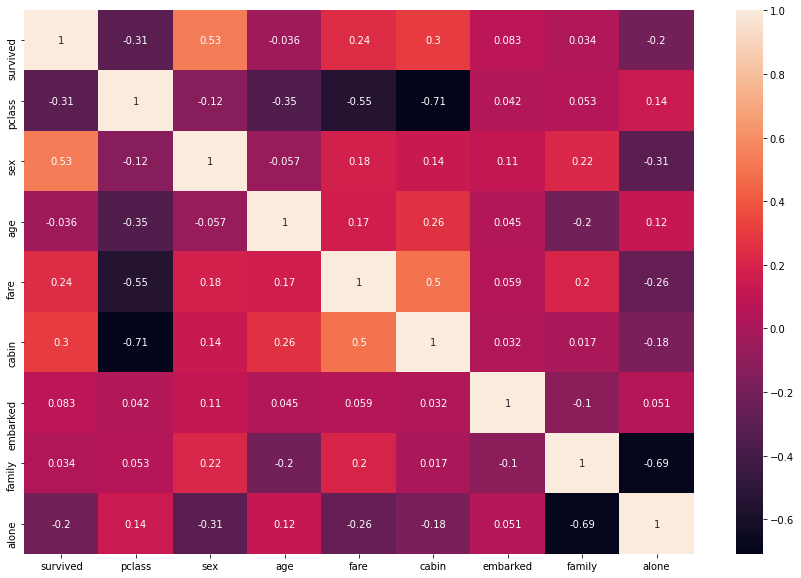

In [221]:
sns.heatmap(data.corr(), annot=True)
plt.show()

We can see that there is a negative high correlation between cabin and pclass. That means that information about cabin is basically included in pclass feature. however,I will not merge this features becuase of potential outliers and also to prevent overfitting.

# Training - baseline

As a baseline model I chose simple decision tree, to see how well it does on validation set.

### Data splitting and model selection

In [222]:
model = DecisionTreeClassifier(max_depth=10)

labels = data['survived']
feature_data = data.drop(columns=['survived'])

rd_seed = 333
train_data, val_data, train_labels, val_labels = train_test_split(feature_data, labels, test_size=0.25, random_state=rd_seed) 

### Training and evaluation

Let's try a simple model for sanity check.

In [223]:
model.fit(train_data, train_labels)

DecisionTreeClassifier(max_depth=10)

In [224]:
predictions = model.predict(val_data)
print("Model accuracy on validation set: ", 100*accuracy_score(val_labels,predictions), '%')

Model accuracy on validation set:  76.4 %


let's plot confusion matrix:

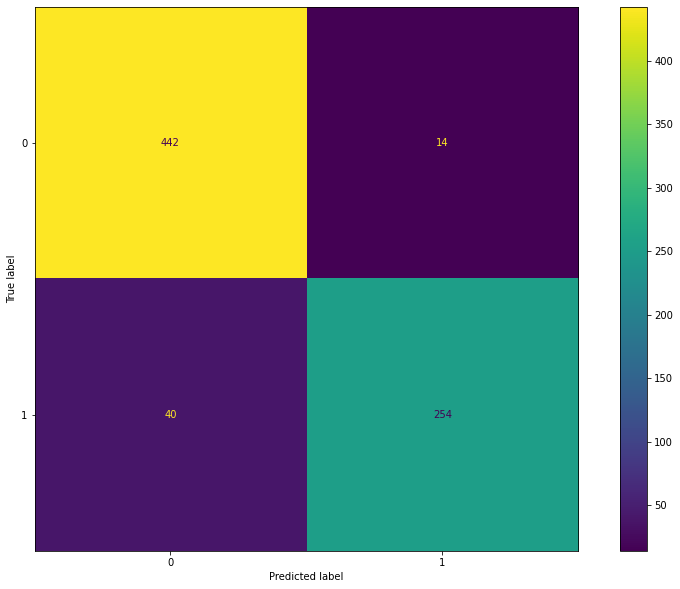

In [225]:
plot_confusion_matrix(model, train_data, train_labels)  
plt.show()

As we can see, our validation set is imbalanced.Hence we might want to use more robust metric. I will use F1 score for this.

In [226]:
print(100*f1_score(val_labels,predictions,average='macro'),'%')

73.63199199127621 %


In [227]:
survived = train_labels[train_labels==1].count()
not_survived = train_labels[train_labels==0].count()
print('Survived',survived/len(train_labels)*100,'%')
print('not-survived',not_survived/len(train_labels)*100,'%')

Survived 39.2 %
not-survived 60.8 %


Our model tends to to classify 0 more often due to the class imbalance in training set. We will deal with this imbalance in more sophisticated model section.

### Hyperparam tuning

In [228]:
param_grid = {
    'max_depth': range(1,51), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)

In [229]:
val_acc = []
for params in param_comb:
    model = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    model.fit(train_data, train_labels)
    val_acc.append(accuracy_score(val_labels, model.predict(val_data)))

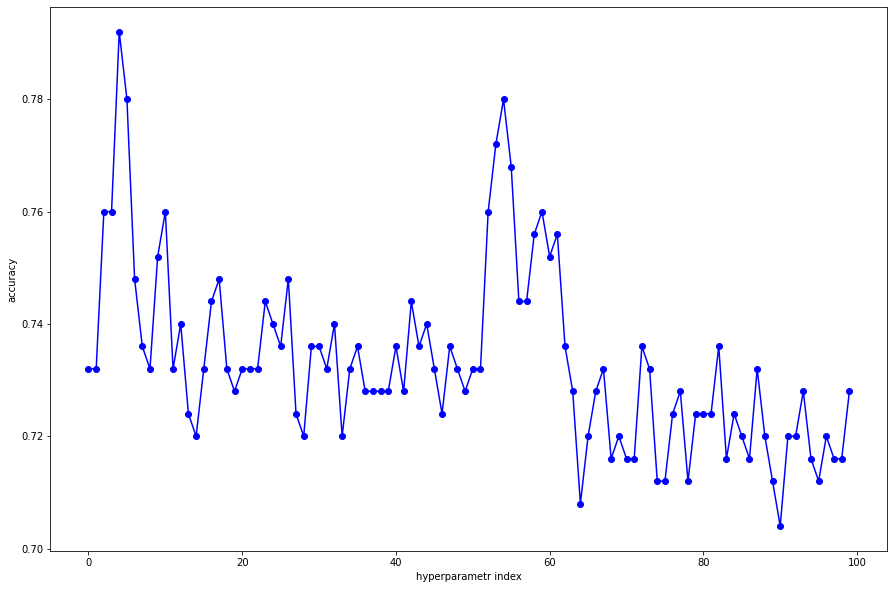

In [230]:
plt.figure(figsize=(15,10))
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.show()

In [231]:
best_idx = np.argmax(val_acc)

best_params = param_comb[best_idx]
print(best_params)
print(val_acc[best_idx])

best_model_decisiontree = DecisionTreeClassifier(max_depth=best_params['max_depth'],criterion=best_params['criterion'])
best_model_decisiontree.fit(train_data,train_labels)

{'max_depth': 5, 'criterion': 'entropy'}
0.792


DecisionTreeClassifier(criterion='entropy', max_depth=5)

## Prediction on evaluation dataset

We will once again clean the data, for this purpose a defined each cleaning step as a function and can now define whole pipeline as a composition of functions

In [234]:
test_data = pd.read_csv('data/evaluation.csv')
ids = test_data['ID'].to_numpy()

In [235]:
clean_data  = compose(remove_cols,family_feature,map_features,impute_nans)

In [236]:
cleaned_eval = clean_data(test_data)

In [237]:
predictions = best_model_decisiontree.predict(cleaned_eval)

In [238]:
fields = ['ID','survived']
merged = np.column_stack((ids,predictions))

with open('data/baseline_model_results.csv', 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
    # writing the fields 
    csvwriter.writerow(fields) 
    # writing the data rows 
    csvwriter.writerows(merged)

## Using better models

in this section I will compare three ensemble methods: **Random forest, Adaboost, Gradient boosting**.
For validation we will use 5-fold cross validation

In [118]:
data = pd.read_csv('data/data.csv')
data = clean_data(data)

In [189]:
labels = data['survived']
features = data.drop(columns=['survived'])

## Decision Tree

For better evaluation of methods, i will finetune simple decision tree model once again but with cross validation

In [196]:
param_grid = {
    'max_depth': range(1,41), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)

In [197]:
val_scores_dectree = []
for params in param_comb:
    model = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    model.fit(train_data, train_labels)
    val_scores_dectree.append(accuracy_score(val_labels, model.predict(val_data)))

In [198]:
best_idx = np.argmax(val_scores_dectree)

best_params = param_comb[best_idx]
print(best_params)
print(val_scores_dectree[best_idx])

best_model_decisiontree = DecisionTreeClassifier(max_depth=best_params['max_depth'],criterion=best_params['criterion'])
best_model_decisiontree.fit(train_data,train_labels)

{'max_depth': 5, 'criterion': 'entropy'}
0.792


DecisionTreeClassifier(criterion='entropy', max_depth=5)

## Random forest

as hyperparameters we wil use: **n_estimators,max_depth,min_samples_split,min_samples_leaf**

In [140]:
param_grid = {
    'n_estimators': [30,50,100,200], 
    'max_depth': [10, 20, 50, 100],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [8, 10, 12],
}
param_comb = ParameterGrid(param_grid)

In [141]:
val_scores_forest=[]

for params in tqdm(param_comb):
    model = RandomForestClassifier(max_depth=params['max_depth'],n_estimators=params['n_estimators'],min_samples_leaf=params['min_samples_leaf'],
                                   min_samples_split=params['min_samples_split'],criterion='entropy')
    scores = cross_val_score(model,features,labels,cv=5)
    val_scores_forest.append(np.mean(scores))

100%|██████████| 144/144 [03:21<00:00,  1.40s/it]


In [148]:
best_idx = np.argmax(val_scores_forest)

best_params = param_comb[best_idx]
print(best_params)
print(val_scores_forest[best_idx])

best_model_randomforest = RandomForestClassifier(max_depth=best_params['max_depth'],n_estimators=best_params['n_estimators'],
                                                 min_samples_leaf=best_params['min_samples_leaf'],min_samples_split=best_params['min_samples_split'],
                                                 criterion='entropy')
best_model_randomforest.fit(features,labels)

{'n_estimators': 30, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 10}
0.8150000000000001


RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=30)

## Adaboost

We will take exactly same approach only with adaboost classifier. It is clear that model choice is in a way just another hyperparameter. We will use Decision Tree as base clasifier, we will tune it's max depth.

hypereparameters: **max depth, n_estimators,learning_rate,algorithm**

In [167]:
param_grid = {
    'n_estimators': [50,100,200], 
    'max_depth': [10,20,50,70],
    'learning_rate': [0.01,0.05,0.1,0.2,0.5,1.0],
    'algorithm': ['SAMME', 'SAMME.R'],
}
param_comb = ParameterGrid(param_grid)

In [168]:
val_scores_adaboost=[]

for params in tqdm(param_comb):
    model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=params['max_depth']),n_estimators=params['n_estimators'],
                              learning_rate=params['learning_rate'],algorithm=params['algorithm'])
    scores = cross_val_score(model,features,labels,cv=5)
    val_scores_adaboost.append(np.mean(scores))

100%|██████████| 144/144 [08:08<00:00,  3.39s/it]


In [169]:
best_idx = np.argmax(val_scores_adaboost)

best_params = param_comb[best_idx]
print(best_params)
print(val_scores_adaboost[best_idx])

best_model_adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=params['max_depth']),n_estimators=params['n_estimators'],
                              learning_rate=params['learning_rate'],algorithm=params['algorithm'])
best_model_adaboost.fit(features,labels)

{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'algorithm': 'SAMME'}
0.78


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=70),
                   n_estimators=200)

## Choose the best model

In [203]:
dec_tree = np.mean(cross_val_score(best_model_decisiontree,features,labels,cv=5))
random_forest = np.mean(cross_val_score(best_model_randomforest,features,labels,cv=5))
adaboost = np.mean(cross_val_score(best_model_adaboost,features,labels,cv=5))

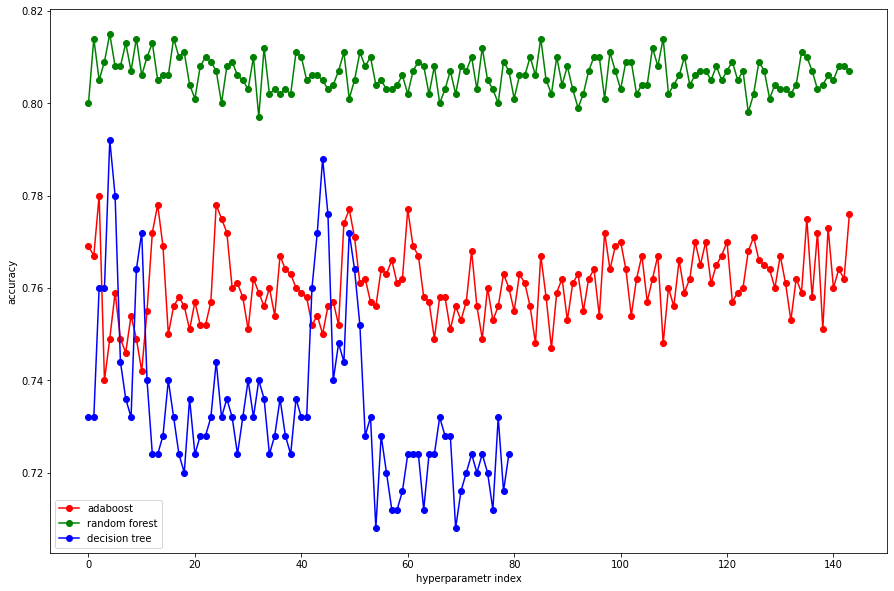

In [204]:
plt.figure(figsize=(15,10))
plt.plot(val_scores_adaboost,'or-')
plt.plot(val_scores_forest,'og-')
plt.plot(val_scores_dectree,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['adaboost', 'random forest','decision tree'])
plt.show()

We will use random forest model as it performs best. However, poor performance of adaboost was also because of poor choice of hyperparameters. That was partialy because of lack of computation power to search in bigger hyperparam space.

## Prediction on evaluation set

In [207]:
test_data = pd.read_csv('data/evaluation.csv')
ids = test_data['ID'].to_numpy()

clean_data  = compose(remove_cols,family_feature,map_features,impute_nans)
cleaned_eval = clean_data(test_data)

In [209]:
predictions = best_model_randomforest.predict(cleaned_eval)

fields = ['ID','survived']
merged = np.column_stack((ids,predictions))

with open('data/results.csv', 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
    # writing the fields 
    csvwriter.writerow(fields) 
    # writing the data rows 
    csvwriter.writerows(merged)